# Loading all the individual zarrs and trying to write to one big zarr


In [1]:
import dask
import dask.distributed 
import numpy as np
from dask.distributed import performance_report


In [41]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43171")
client

<Client: 'tcp://127.0.0.1:43171' processes=4 threads=16, memory=58.87 GiB>

In [8]:
#import dask
dask.config.set(scheduler='synchronous')

In [2]:
dask.config.config['distributed']['scheduler']['worker-saturation'] = 1.0

In [3]:
#dask.config.set({"distributed.scheduler.worker-saturation": 1.0}) 

In [3]:
import xarray as xr
import fsspec
import json

with open('../../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

# This one is working
but only with 16 cores, increasing this causes biggerer to fail

In [5]:
site = "A101"
ds_all = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_3/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)

In [10]:
ds_all['attenuator'] = ds_all.attenuator[14]
ds_all['AFGain'] = ds_all.AFGain[14]

In [24]:
ds_all

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [30]:
ds_small = ds_all.isel(time=slice(0,1600))
ds_bigger = ds_all.isel(time=slice(0,5000))
ds_biggerer = ds_all.isel(time=slice(0,8000))

In [23]:
# worked with 16 cores
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_small' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_small.to_zarr(mapper, consolidated=True, safe_chunks=False)

KeyboardInterrupt: 

In [28]:
# worked with 16 cores
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_bigger_2' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_bigger.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [33]:
# worked with 16 cores
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_biggerer_2' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report('biggerer.html'):
    ds_biggerer.to_zarr(mapper, consolidated=True, safe_chunks=False)

### Try add the stacked profile and rechunking to longer time chunks before writing
try first on the smallest subset --- this works with 16 cores

In [34]:
profile_stacked = ds_small.profile.mean(dim='chirp_num')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [69]:
for var in ds_small:
    print(var)
    del ds_small[var].encoding['chunks']

ds_small_stacked = ds_small.assign({'profile_stacked':profile_stacked})
print(ds_small_stacked.chirp.encoding)

battery_voltage
chirp
latitude
longitude
profile
temperature_1
temperature_2
{'preferred_chunks': {'time': 1, 'chirp_time': 40001, 'chirp_num': 20, 'attenuator_setting_pair': 2}, 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0), 'filters': None, '_FillValue': nan, 'dtype': dtype('float64'), 'coordinates': 'AFGain filename burst_number attenuator'}


In [73]:
ds_small_stacked_rechunked = ds_small_stacked.chunk({'time':20})
ds_small_stacked_rechunked

battery_voltage


KeyError: 'chunks'

In [75]:
# worked with 16 cores
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_small_stacked_rechunked_3' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report('small_stacked_rechunked.html'):
    ds_small_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [77]:
ds_small_stacked_rechunked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_small_stacked_rechunked_reloaded.chirp.encoding

{'chunks': (20, 40001, 20, 2),
 'preferred_chunks': {'time': 20,
  'chirp_time': 40001,
  'chirp_num': 20,
  'attenuator_setting_pair': 2},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'AFGain filename burst_number attenuator'}

2022-11-24 16:33:51,742 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


try with the biggerer subset

In [44]:
for var in ds_biggerer:
    print(var)
    del ds_biggerer[var].encoding['chunks']

profile_stacked = ds_biggerer.profile.mean(dim='chirp_num')
ds_biggerer_stacked = ds_biggerer.assign({'profile_stacked':profile_stacked})
ds_biggerer_stacked_rechunked = ds_biggerer_stacked.chunk({'time':20})
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_biggerer_stacked_rechunked_2' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report('biggerer_stacked_rechunked.html'):
    ds_biggerer_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [51]:
ds_biggerer_stacked_rechunked.chirp.encoding['chunks']

(1, 40001, 20, 2)

In [45]:
ds_biggerer_stacked_rechunked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_biggerer_stacked_rechunked_reloaded

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 8000,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-08-17...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [5]:
#site = "A101"
def zarrs_to_onezarr(site):
    ds_all = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_3/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)
    ds_all['attenuator'] = ds_all.attenuator[14]
    ds_all['AFGain'] = ds_all.AFGain[14]

    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}' 
    mapper = fsspec.get_mapper(filename, mode='w', token=token) 
    with performance_report():
        ds_all.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [ ]:
zarrs_to_onezarr("A101")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## ideal chunks

We would like our key variables `chirp` and `profiles` to be in chinks of 100-200 MB. 

- Probably need to be 20 in the `chirp_num` dimension. 
- can be 1 in the `attenuator setting pair` dimension.
- they should be 40001 and 6658, respectively, in the `chirp_time` and `profile_range` dimensions

# 1. One test is to load a subset (which has all time chunks the same) and see if we can save it to zarr

In [18]:
datasets = []

names = [f'gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_{num}' for num in range(0,127)]

for name in names[0:5]:
    ds = xr.open_dataset(name,
                         chunks = {}, 
                         engine = 'zarr', 
                         consolidated = False)
    print(ds.profile.chunks)
    datasets.append(ds)
    print(name)


((4, 4, 4, 1), (1665, 1665, 1665, 1663), (10, 10), (1, 1))
gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_0
((1,), (3329, 3329), (10, 10), (1, 1))
gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_1
((12, 12, 12, 12, 12, 12, 12, 10), (1665, 1665, 1665, 1663), (5, 5, 5, 5), (1, 1))
gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_2
((12, 12, 12, 12, 12, 12, 12, 10), (1665, 1665, 1665, 1663), (5, 5, 5, 5), (1, 1))
gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_3
((12, 12, 12, 12, 12, 12, 12, 10), (1665, 1665, 1665, 1663), (5, 5, 5, 5), (1, 1))
gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat_4


In [21]:
ds.profile.encoding

{'chunks': (12, 1665, 5, 1),
 'preferred_chunks': {'time': 12,
  'profile_range': 1665,
  'chirp_num': 5,
  'attenuator_setting_pair': 1},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'dtype': dtype('complex128'),
 'coordinates': 'AFGain attenuator burst_number filename'}

In [22]:
ds.profile

AttributeError: 'DataArray' object has no attribute 'chunksize'

In [23]:
ds_all = xr.concat(datasets,dim='time')
ds_all

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 2538,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 -4 -14
    attenuator       (attenuator_setting_pair) float64 5.0 5.0
    burst_number     (time) int64 dask.array<chunksize=(94,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(94,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-27T15:06:30 ... 2022-06-23...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(12, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(12, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>

In [24]:
#for var in ds_all:
#    del ds_all[var].encoding['chunks']

In [25]:
ds_all.nbytes/1e9

43.303292928

Save to zarr then reload to check it is all there. 

In [26]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_30_norechunk' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 

ds_all.to_zarr(mapper, consolidated=False, safe_chunks=False)

In [28]:
ds_all_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=False, chunks={}) 
ds_all_reloaded

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 2538,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(94,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(94,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-27T15:06:30 ... 2022-06-23...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(12, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(12, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>

# 2. Use mfdataset to open all the individual zarrs.
This works as a way of getting all the data, but the time chunks are non-uniform, so they cannot be written directly to zarr without rechunking. 

In [76]:
ds_all = xr.open_mfdataset("gs://ldeo-glaciology/GL_apres_2022_individual_zarrs_all_4/dat*",
                           chunks = {}, 
                           engine = 'zarr', 
                           consolidated = False, 
                           parallel = True)
ds_all

OSError: no files to open

# 3. take a subset (similar to the first small subset in #1 and write that.
This subset has uniform time chunks, so it can be succcesfully written. 

In [79]:
ds_all_smaller = ds_all.isel(time=slice(14,2538))
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_30_from_ds_all_norechunk_3' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 

ds_all_smaller.to_zarr(mapper, consolidated=False, safe_chunks=False)

ds_all_smaller_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=False, chunks={}) 
ds_all_smaller_reloaded

<xarray.Dataset>
Dimensions:          (time: 2524, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(94, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(94, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-06-21...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(4, 10001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(4, 1665, 10, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>

In [13]:
#for var in ds_all:
#    del ds_all[var].encoding['chunks']


# 4. Crop the first few time slices (which have different time chunks) and rechunk the minimum ammount which results in uniform time chunks.
This doesnt work. The memory of the NB machine fills and crashes. 

In [9]:
ds_all_cropped = ds_all.isel(time=slice(14,None))
ds_all_cropped_rechunked = ds_all_cropped.chunk({'time' : 940,'attenuator_setting_pair': 1, 'profile_range': 1665})
ds_all_cropped_rechunked

<xarray.Dataset>
Dimensions:          (time: 11709, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(940,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(940,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(940, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(940, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>

In [11]:
from dask.diagnostics import ProgressBar

In [12]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_end_some_rechunking_6_synchronous' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 

with dask.config.set(scheduler='synchronous'):
    with ProgressBar():
        ds_all_cropped_rechunked.to_zarr(mapper, consolidated=False, safe_chunks=False)


[                                        ] | 0% Completed | 261.34 ss


KeyboardInterrupt: 

In [ ]:
from dask.distributed import performance_report

filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_end_some_rechunking_5' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_all_cropped_rechunked.to_zarr(mapper, consolidated=False, safe_chunks=False)

ds_all_cropped_rechunked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=False, chunks={}) 
ds_all_cropped_rechunked_reloaded

# 5. Try stacking the profiles and then writing. 
This works.

In [15]:
ds_all_cropped = ds_all.isel(time=slice(14,None))
del ds_all_cropped['chirp']
del ds_all_cropped['chirp_time']

In [19]:
ds_all_cropped_stacked = ds_all_cropped.mean(dim='chirp_num')
ds_all_cropped_stacked.persist()

<xarray.Dataset>
Dimensions:          (time: 11709, attenuator_setting_pair: 2,
                      profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(94, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(94, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(94,), meta=np.ndarray>
    filename         (time) <U83 dask.array<chunksize=(94,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    profile          (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(12, 1665, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>

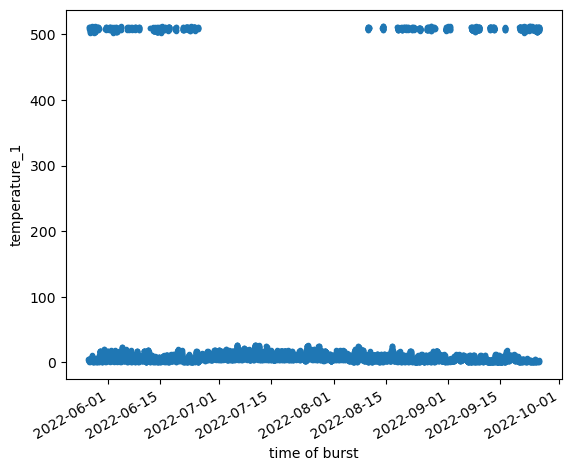

In [56]:
ds_all_cropped_stacked.temperature_1.plot(marker = '.', linestyle = '')

In [42]:
ds_all_cropped_stacked.nbytes/1e9

2.499643748

In [41]:
from dask.distributed import performance_report

ds_all_cropped_stacked = ds_all_cropped_stacked.chunk({'time' : 94,'attenuator_setting_pair': 1, 'profile_range': 6658})

filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_end_some_rechunking_stacked_2' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_all_cropped_stacked.to_zarr(mapper, consolidated=False, safe_chunks=False)



2022-11-22 04:04:48,566 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2022-11-22 04:04:48,574 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


CommClosedError: ConnectionPool closing.

In [2]:
import xarray as xr
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just3_end_some_rechunking_stacked_2' 

ds_all_cropped_stacked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=False, chunks={}) 
ds_all_cropped_stacked_reloaded

<xarray.Dataset>
Dimensions:          (time: 11709, attenuator_setting_pair: 2,
                      profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(94, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(94, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    profile          (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(94, 6658, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>

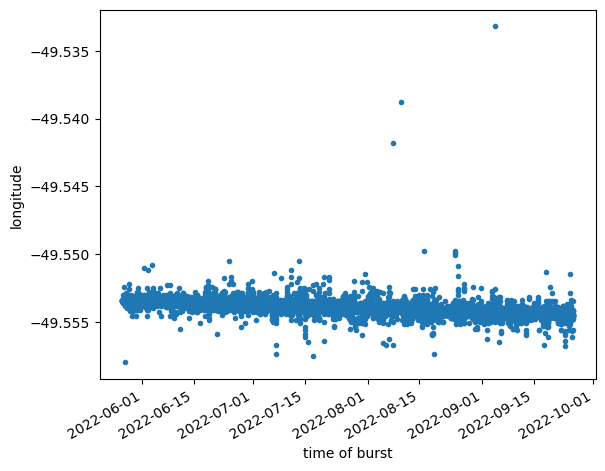

In [5]:
ds_all_cropped_stacked_reloaded.longitude.plot(marker = '.', linestyle = '')

# 6. Try stacking before rechunk and save, but including all zarrs and doing a little more rechunking, and consolidated = True
The rechunkng makes the chunks 95MB instead of 9.5MB.

This works, but the reloaded dataset has inconsitent chunks again!

In [5]:
ds_all_copy = ds_all.copy()
del ds_all_copy['chirp']
del ds_all_copy['chirp_time']

In [6]:
ds_all_copy_stacked = ds_all_copy.mean(dim='chirp_num')
ds_all_copy_stacked.persist()

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    profile          (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(4, 1665, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>

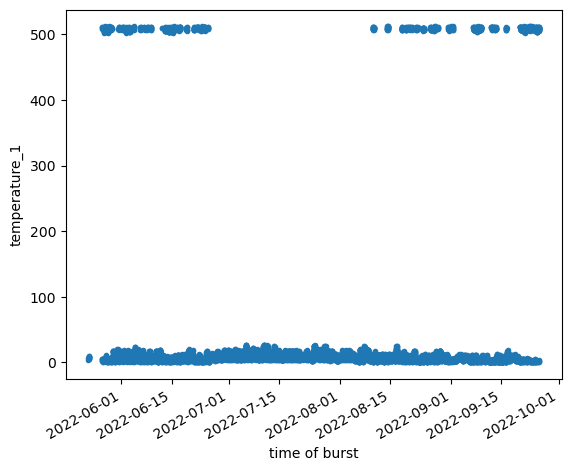

In [7]:
ds_all_copy_stacked.temperature_1.plot(marker = '.', linestyle = '');

In [8]:
ds_all_copy_stacked.nbytes/1e9

2.502632412

In [27]:
ds_all_copy_stacked = ds_all_copy_stacked.chunk({'time' : 940,'attenuator_setting_pair': 1, 'profile_range': 6658})
ds_all_copy_stacked.profile.chunksizes

Frozen({'time': (940, 940, 940, 940, 940, 940, 940, 940, 940, 940, 940, 940, 443), 'profile_range': (6658,), 'attenuator_setting_pair': (1, 1)})

2022-11-22 16:03:00,753 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [18]:

filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just_all_more_rechunking_stacked_3' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_all_copy_stacked.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [22]:


import xarray as xr
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_just_all_more_rechunking_stacked_2' 

ds_all_copy_stacked_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_all_copy_stacked_reloaded

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    filename         (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    profile          (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(940, 6658, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(940,), meta=np.ndarray>

In [26]:
ds_all_copy_stacked_reloaded.profile.chunk

<bound method DataArray.chunk of <xarray.DataArray 'profile' (time: 11723, profile_range: 6658,
                             attenuator_setting_pair: 2)>
dask.array<open_dataset-08ca91d245897684ab5e922742fead04profile, shape=(11723, 6658, 2), dtype=complex128, chunksize=(940, 6658, 1), chunktype=numpy.ndarray>
Coordinates:
    AFGain         (time, attenuator_setting_pair) int64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    attenuator     (time, attenuator_setting_pair) float64 dask.array<chunksize=(940, 1), meta=np.ndarray>
    burst_number   (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    filename       (time) <U83 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25T1...
Dimensions without coordinates: attenuator_setting_pair>

# 7. Load the prechunked data and try with that
This is data what has been chunked with 
`ds = xa.data.chunk({'time':1,'attenuator_setting_pair':-1, 'chirp_num':-1, 'profile_range': -1, 'chirp_time':-1  })
`
before writing to individual zarrs.


In [23]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33081")
client

<Client: 'tcp://127.0.0.1:33081' processes=4 threads=16, memory=58.87 GiB>

In [66]:
site = "A101"

ds_all = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_3/dat_*',
                           chunks = {}, 
                           engine = 'zarr', 
                           consolidated = False, 
                           parallel = True)
ds_all

<xarray.Dataset>
Dimensions:          (time: 1612, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(13, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-06-12...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [67]:
ds_all['attenuator'] = ds_all.attenuator[14]
ds_all['AFGain'] = ds_all.AFGain[14]

In [71]:
ds_all.nbytes/1e9

27.5040402

In [68]:
ds_all

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 1612,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-06-12...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [73]:
%%time    
# with 16 cores, 27GB
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_small_prechunked_6_consolidated' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report():
    ds_all.to_zarr(mapper, consolidated=True, safe_chunks=False)

KeyboardInterrupt: 

2022-11-23 19:28:45,873 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [65]:
ds_all_prechunked_reloaded_consolidated = xr.open_dataset(filename, engine='zarr', consolidated=True, chunks={}) 
ds_all_prechunked_reloaded_consolidated

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 766, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-06-03...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 6658, 20, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [25]:
datasets = []

names = [f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked/dat_{num}' for num in range(0,127)]

for name in names[0:5]:
    ds = xr.open_dataset(name,
                         chunks = {}, 
                         engine = 'zarr', 
                         consolidated = False)
    print(ds.profile.chunks)
    datasets.append(ds)
    print(name)


((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (6658,), (20,), (2,))
gs://ldeo-glaciology/apres/greenland/2022/A101/individual_zarrs_prechunked/dat_0
((1,), (6658,), (20,), (2,))
gs://ldeo-glaciology/apres/greenland/2022/A101/individual_zarrs_prechunked/dat_1
((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (6658,), (20,), (2,))
gs://ldeo-glaciology/apres/greenland/2022/A101/individual_zarrs_prechunked/dat_2
((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (6658,), (20,), (2,))
gs://ldeo-glaciology/apres/greenland/2022/A101/ind

In [41]:
print(ds_all.profile.chunks)
print(ds_all.profile.chunksizes)


((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

ValueError: Object has inconsistent chunks along dimension time. This can be fixed by calling unify_chunks().

# 8. Play with reloaded results

In [ ]:
import numpy as np
dB = 20*np.log10(np.abs(ds_all_cropped_stacked_reloaded.profile))
dB.isel(time=11000).plot.line(x='profile_range');

In [40]:
del ds_all_cropped_stacked_reloaded['filename']
ds_all_cropped_stacked_reloaded

<xarray.Dataset>
Dimensions:          (time: 11709, attenuator_setting_pair: 2,
                      profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(94, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(94, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(13,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    profile          (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(94, 6658, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(94,), meta=np.ndarray>

In [ ]:
np.abs(ds_all_cropped_stacked_reloaded.profile[:,:,1]).coarsen(time=96, boundary = 'pad').mean().plot()

Task exception was never retrieved
future: <Task finished name='Task-6621' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6622' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-6623' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.

This is the chunking scheme I would actually like, but I dont know how to achieve it when the 

In [11]:
ds_all_rechunked = ds_all.chunk({'time' : 10, 'chirp_num' : -1, 'chirp_time': -1, 'attenuator_setting_pair': 1, 'profile_range': -1})
ds_all_rechunked

<xarray.Dataset>
Dimensions:          (time: 11723, attenuator_setting_pair: 2,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(10, 1), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(10, 1), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(10,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(10,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(10, 40001, 20, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(10, 6658, 20, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>

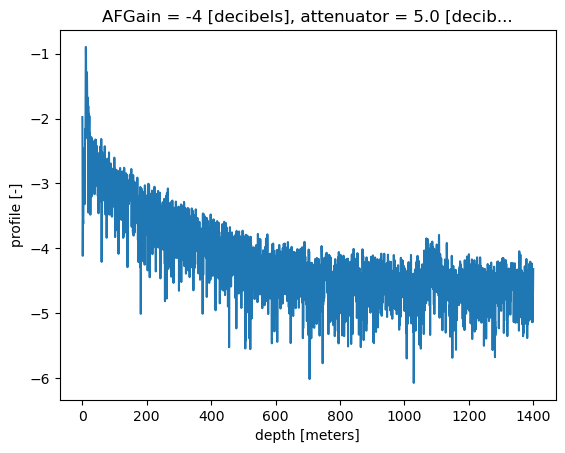

In [12]:
import numpy as np
20*np.log10(np.abs(ds_all_rechunked.profile.isel(time=[11300],attenuator_setting_pair=0,chirp_num=0))).plot();

In [24]:
ds_all_rechunked.longitude[0].values

array(-51.1188)

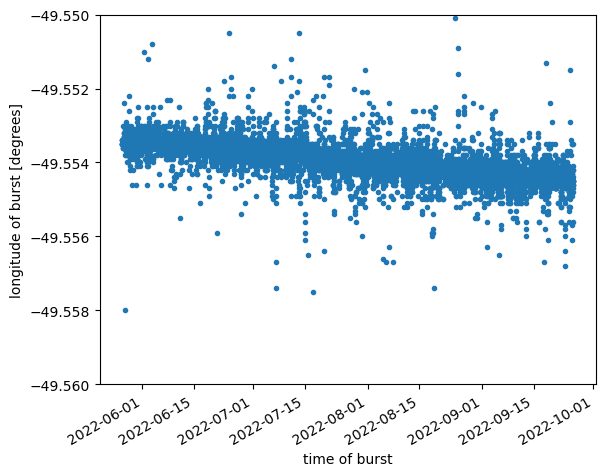

In [26]:
ds_all_rechunked.longitude[14:].plot(marker='.', linestyle='', ylim = (-49.560, -49.550));

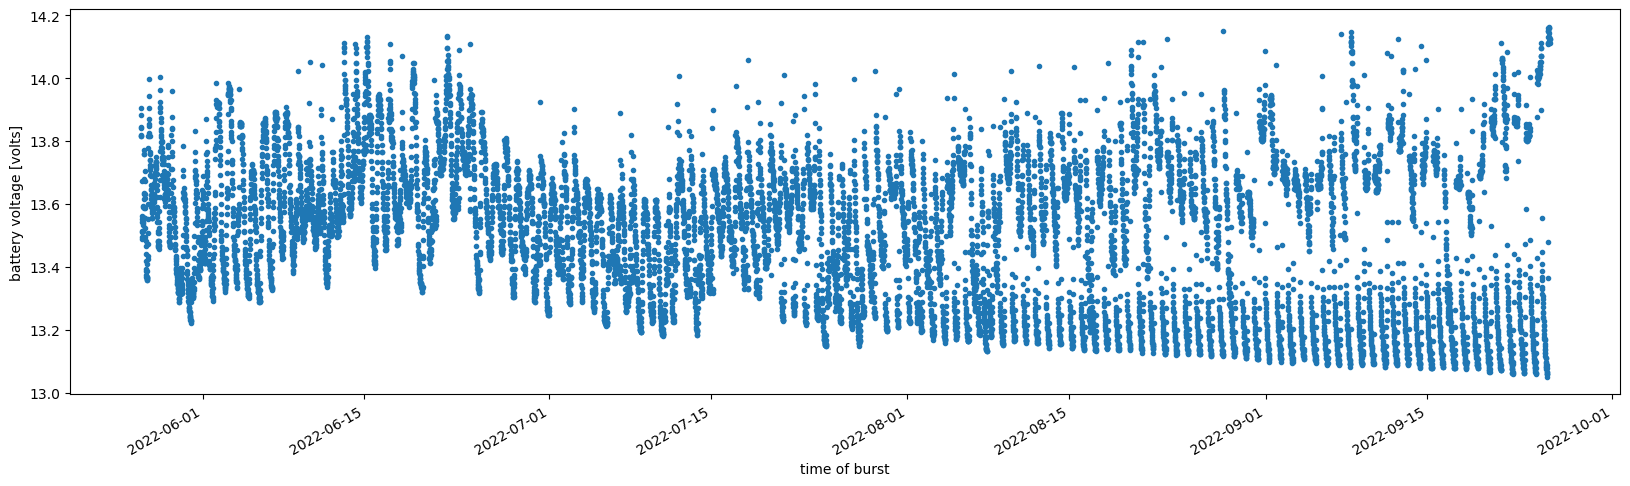

In [30]:
ds_all_rechunked.battery_voltage[14:].plot(marker='.', linestyle='', figsize=(20,5));

In [15]:
ds_all_rechunked.nbytes/1e9

200.016558212

In [9]:
filename = 'gs://ldeo-glaciology/GL_apres_2022/A101_all_10_norechunk' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 

ds_all.to_zarr(mapper, consolidated=False, safe_chunks=False)

ValueError: Zarr requires uniform chunk sizes except for final chunk. Variable named 'AFGain' has incompatible dask chunks: ((13, 1, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 78, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 69), (2,)). Consider rechunking using `chunk()`.

In [18]:
import numpy as np
import dask.array as da

data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [19]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [21]:
del a